# Anomaly Detection

#### Contents
- [Overview](#Overview)
##### Density based Anomaly Detection
- [Gaussian Density Estimation](#gaussian-density-estimation)
- [MoG (Mixture of Gaussians)](#mixture-of-gaussians-mog)
    - [Expectation Maximization Algorithm](#expectation-maximization-algorithm)
    - [Different Covariance Matricies](#different-covariance-matricies)
- [Kernel Density Estimation](#kernel-density-estimation)
    - [Different Kernel Functions](#different-kernel-functions)

##### Model based Anomaly Detection
- [Isolation Forest](#isolation-forest)
    - [Training and Inference](#training-and-inference)

------------

## Overview

<p align="center">
    <img src="anomaly_images/blacksheep.png" width="400"/>
</p>


> Novel data are observations that deviate so much from other observations that they appear to have been generated by a different mechanism. - Hawkins, 1980

Anomaly detection, 즉 이상치 탐지는 정상 범주에서 벗어난 데이터를 탐지하는 Unsupervised 머신러닝의 task 중 하나이다. 이때 이상치와 노이즈 데이터는 엄밀히 구분되어야 한다. 이상치는 정상 데이터와 다른 분포를 가지고 있으며, 노이즈는 측정 과정에서의 무작위성에서 기반된다. 데이터셋 속 이상치는 대부분 엄청난 class imbalance 를 가지고 있으며, 이는 이상치 탐지의 어려움을 더욱 높인다.

<p align="center">
    <img src="anomaly_images/classvsanom2.png" width="400"/>
</p>


위와 같은 예시를 보면, 분류 문제와 이상치 탐지의 차이점을 쉽게 이해할 수 있다. 이상치 탐지는 다량의 정상 데이터를 통해 정상 범주를 정의하는 반면, 분류 문제는 두개의 범주를 가장 잘 설명하는 분류기를 fitting 한다.

<p align="center">
    <img src="anomaly_images/applications.png" width="400"/>
</p>


이상치 탐지는 굉장히 다양한 산업 분야에서 사용되며, 이에 다양한 방법론들 또한 존재한다. 이상치 탐지 방법론들은 크게 밀도 기반 방법론과 모델 기반 방법론으로 분류되며, 먼저 밀도 기반 방법론부터 알아보고자 한다.

-------------

## Density based Anomaly Detection

밀도 기반 이상치 탐지는 데이터의 밀도를 이용하여 이상치를 탐지한다. 주어진 데이터를 바탕으로 데이터가 생성되었을 분포를 fitting 한 뒤, 특정 객체가 해당 분포에서 생성되었을 확률이 낮다면 해당 객체를 이상치로 분류하는 방법론들이다.

In [78]:
import pandas as pd
import numpy as np
import scipy
import random
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore")
df = pd.read_csv('creditcard.csv')

사용한 데이터는 [Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download&select=creditcard.csv) 으로, 총 284,807 개의 샘플 중 492 개의 이상치를 가지고 있다. 실제 사용자들의 데이터로 구성되어 있기 때문에 변수명은 인코딩 되어있으며, `Class` 변수는 binary 값으로 0은 정상 데이터, 1은 이상치 데이터를 의미한다. 이상치의 비율은 0.172%로 굉장히 낮으므로, 이상치 탐지에서 자주 사용되는 데이터셋이다.

In [2]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

### Gaussian Density Estimation

Gaussain Density Estimation 은 밀도 기반 이상치 탐지 중 가장 기본적인 방법론이다. 이 방법론은 데이터를 가장 잘 설명하는 unimodal Gaussian 분포를 fitting 한 뒤, 특정 객체가 해당 분포에서 생성되었을 확률을 계산하여 이상치를 탐지한다. 이때, Gaussian 분포의 parameter 는 Maximum Likelihood Estimation (MLE) 을 통해 fitting 한다.

현재로썬 데이터셋의 변수들이 무엇을 의미하는지 모르기 때문에, 2개의 변수를 랜덤 추출하여 Gaussian 을 fitting 해보고자 한다.

In [16]:
varlist = df.columns.to_list()
rm = ['Time', 'Amount', 'Class']
for i in rm:
    varlist.remove(i)
rand_1 = random.choice(varlist)
rand_2 = random.choice(varlist)
print(rand_1, rand_2)

V9 V7


$$
p(\mathbf{x})=\frac{1}{(2 \pi)^{d / 2}|\mathbf{\Sigma}|^{1 / 2}} \exp \left[-\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^T \mathbf{\Sigma}^{-1}(\mathbf{x}-\boldsymbol{\mu})\right]
$$

위 식에서 실제로 추정해야 하는 것은 평균 벡터인 $\mu$ 와 공분산 행렬인 $\Sigma$ 이다. 데이터로 평균 벡터와 공분산 행렬을 구한 뒤, 특정 객체의 생성 확률을 계산 한 뒤, 해당 확률이 cutoff 보다 작다면 객체를 이상치로 판단하는 것이 Gaussian Density Estimation 이다.

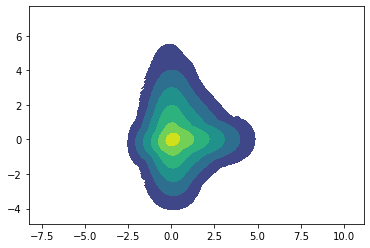

In [17]:
x = np.array(df[rand_1].sample(frac=0.001, random_state=1))
y = np.array(df[rand_2].sample(frac=0.001, random_state=1))
mu = [np.mean(x), np.mean(y)]
cov = [[np.var(x), np.cov(x, y)[0,1]], [np.cov(x, y)[0,1], np.var(y)]]
p = scipy.stats.multivariate_normal(mu, cov)
X, Y = np.meshgrid(x,y)
z = p.pdf(np.dstack([X, Y]))
plt.grid(False)
plt.contourf(X, Y, z)
plt.axis("equal")
plt.show()

위 그래프는 두개의 변수를 통해 평균벡터 `mu` 와 공분산행렬 `cov` 를 구한 뒤, 가우시안 분포를 fitting 한 예시이다. 전체 샘플 수를 사용할 시 메모리 부족으로 인해 0.001 만큼 샘플링을 진행하였다.

In [18]:
x = np.array(df[rand_1])
y = np.array(df[rand_2])
mu = [np.mean(x), np.mean(y)]
cov = [[np.var(x), np.cov(x, y)[0,1]], [np.cov(x, y)[0,1], np.var(y)]]
p = scipy.stats.multivariate_normal(mu, cov)

실제로 fitting 을 진행한 가우시안은 위 코드블럭의 `p` 이다. 데이터에서 샘플을 가져와 가우시안을 통해 확률을 계산해보면 해당 샘플이 이상치인지 판단 할 수 있게 된다.

In [19]:
anomaly_sample = df.loc[df.Class==1].iloc[0]
regular_sample = df.loc[df.Class==0].iloc[0]
anomaly_sample = np.array(anomaly_sample[[rand_1, rand_2]])
regular_sample = np.array(regular_sample[[rand_1, rand_2]])
print(f'Probability of the anomaly sample from the fitted Gaussian: {p.pdf(anomaly_sample)}')
print(f'Probability of the regular sample from the fitted Gaussian: {p.pdf(regular_sample)}')

Probability of the anomaly sample from the fitted Gaussian: 0.0005950126056339912
Probability of the regular sample from the fitted Gaussian: 0.10879578001424255


이상치 객체와 일반범주 객체를 샘플링 한 뒤, 해당 가우시안에서의 확률을 추출해본 결과 이상치의 확률이 현저히 낮은 것을 알 수 있다. 데이터 속 31개의 변수 중 불과 2개만 사용하였는데도 이상치의 확률을 낮게 측정하는 가우시안이 fitting 되었다.

------------------

### Mixture of Gaussians (MoG)

Gaussian Density Estimation 은 데이터가 unimodal 가우시안에서 생성되었다는 아주 강한 가정을 기반에 두고 있다. 하지만 실제 real life 데이터는 그럴 가능성이 매우 낮기 때문에, 여러개의 가우시안의 선형 결합으로 데이터를 표현하여 이상치 탐지에 이용하는 것이 Mixture of Gaussians (MoG) 이다.

$$
g\left(\mathbf{x} \mid \boldsymbol{\mu}_m, \boldsymbol{\Sigma}_m\right)=\frac{1}{(2 \pi)^{d / 2}\left|\boldsymbol{\Sigma}_m\right|^{1 / 2}} \exp \left[\frac{1}{2}\left(\mathbf{x}-\boldsymbol{\mu}_m\right)^T \boldsymbol{\Sigma}_m^{-1}\left(\mathbf{x}-\boldsymbol{\mu}_m\right)\right]
$$

정의할 가우시안의 개수 $m$ 은 hyperparameter이며, 데이터를 통해 $m$ 개의 가우시안의 fitting 을 진행한다.

$$
p(\mathbf{x} \mid \lambda)=\sum_{m=1}^M w_m g\left(\mathbf{x} \mid \boldsymbol{\mu}_m, \mathbf{\Sigma}_m\right)\\

\lambda=\left\{w_m, \boldsymbol{\mu}_m, \mathbf{\Sigma}_m\right\}, \quad m=1, \cdots, M
$$

가우시안들의 선형결합이 Fitting 이 된 후, 객체가 이 혼합 분포에서의 확률을 구하는 식은 위와 같다. 각 $m$ 개의 가우시안에 대한 확률을 구하는 것이 아니라, 가우시안들의 선형결합에서의 확률을 도출하는 것을 알 수 있다.

#### Expectation Maximization Algorithm

Gaussian density estimation 에서의 가우시안은 unimodal 하기 때문에 convex 하며, closed form solution 이 존재한다. 하지만 MoG 는 가우시안들의 선형결합이기 때문에, closed form solution 이 존재하지 않는다. 위 공식을 자세히 보면 실제 학습시켜야 하는 파라미터는 가중치 $w_m$ 인데, 가우시안의 파라미터를 구해야 가중치를 구할 수 있고 가중치를 구해야만 파라미터를 구할 수 있는 loop 에 빠진다.

이렇게 원하는 미지수들을 동시에 최적화 할 수 없을 때, EM 알고리즘을 사용 할 수 있다.

- Expectation: 현재 파라미터를 고정시킨 뒤, 조건부 확률 계산
- Maximization: 파라미터를 update 후 maximize likelihood

In [65]:
varlist = df.columns.to_list()
rm = ['Time', 'Amount', 'Class']
for i in rm:
    varlist.remove(i)
rand_1 = random.choice(varlist)
rand_2 = random.choice(varlist)
rand_3 = random.choice(varlist)
rand_4 = random.choice(varlist)
print(rand_1, rand_2, rand_3, rand_4)

V19 V27 V8 V6


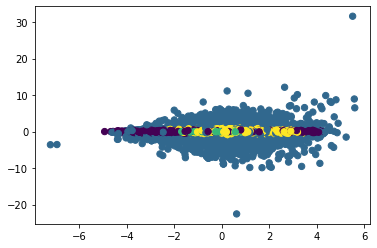

In [66]:
x = np.array(df[[rand_1, rand_2, rand_3, rand_4]])
gmm = GaussianMixture(n_components=4, covariance_type='full').fit(x)
labels = gmm.predict(x)
plt.scatter(x[:, 0], x[:, 1], c=labels, s=40, cmap='viridis');

Gaussian density estimation 예시와 마찬가지로 4개의 변수를 랜덤 추출 후, 4개의 가우시안을 fitting 하였다.

In [67]:
anomaly_sample = df.loc[df.Class==1].iloc[-1]
regular_sample = df.loc[df.Class==0].iloc[-1]
anomaly_sample = np.array(anomaly_sample[[rand_1, rand_2, rand_3, rand_4]])
regular_sample = np.array(regular_sample[[rand_1, rand_2, rand_3, rand_4]])
print(f'Probability of the anomaly sample from the fitted Gaussian: {gmm.predict_proba(anomaly_sample.reshape(1, -1))}')
print(f'Probability of the regular sample from the fitted Gaussian: {gmm.predict_proba(regular_sample.reshape(1, -1))}')

Probability of the anomaly sample from the fitted Gaussian: [[1.39436162e-02 1.12188080e-04 9.34875266e-01 5.10689299e-02]]
Probability of the regular sample from the fitted Gaussian: [[0.04473958 0.00099559 0.66543428 0.28883055]]


이상치 객체와 일반범주 객체를 샘플링 한 뒤, 각 가우시안에서 객체들이 생성되었을 확률을 계산해본 결과, 이상치 객체의 확률들이 일반범주 객체의 확률들보다 낮은 것을 볼 수 있다.


#### Different Covariance Matricies

이상치 탐지의 많은 방법론들 중 거리 기반 이상치 탐지의 k-NN 알고리즘은 데이터의 클러스터 모델이 원형이 아니면 잘 작동하지 않는다는 단점이 있다. 반면 MoG 는 데이터의 클러스터가 원형이 아니더라도 잘 작동한다는 장점이 있다. 이는 fitting 하는 가우시안들의 공분산 행렬의 모형을 바꿈에 따라 그 효과를 살펴 볼 수 있다.

기존에 사용하던 데이터는 가우시안 끼리의 명확한 경계면이 잘 보이지 않기 때문에, 임의의 데이터를 생성 후 시각화 해보고자 한다.

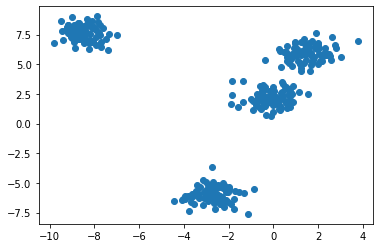

In [79]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=350, centers=4, n_features=2, cluster_std=0.67)
X = X[:, ::-1]
plt.scatter(X[:, 0], X[:, 1], cmap='viridis');

Full:

$$
\Sigma=\left[\begin{array}{ccc}\sigma_{11} & \cdots & \sigma_{1 d} \\ \vdots & \ddots & \vdots \\ \sigma_{d 1} & \cdots & \sigma_{d d}\end{array}\right]
$$


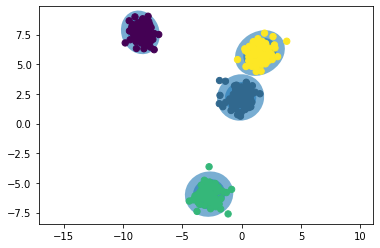

In [84]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()
    
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=3 * w * w_factor)

gmm = GaussianMixture(n_components=4, covariance_type='full')
plot_gmm(gmm, X)


위 예시는 가우시안들의 공분산 행렬을 Full 행렬로 사용한 예시이다. 기존 데이터가 이미 잘 군집되어 있기 때문에 MoG 를 통해 fitting 되는 가우시안들 또한 잘 fitting 되는 것을 볼 수 있다. Full 공분산 행렬을 사용하면 가장 정밀하게 가우시안을 fit 할 수 있다는 장점이 있지만, 계산 복잡도가 높다는 단점이 있다.

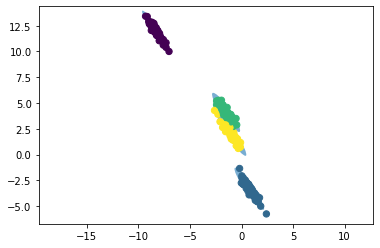

In [85]:
rng = np.random.RandomState(74)
transformation = rng.normal(size=(2, 2))
X_stretched = np.dot(X, transformation)
gmm = GaussianMixture(n_components=4, covariance_type='full')
plot_gmm(gmm, X_stretched)

Full 공분산 행렬을 사용한 MoG 는 데이터 클러스터의 모형이 원형이 아니더라도 가우시안을 잘 fitting 한다는 장점 또한 있다.

Diagonal:

$$
\Sigma=\left[\begin{array}{ccc}
\sigma_1^2 & \cdots & 0 \\
\vdots & \ddots & \vdots \\
0 & \cdots & \sigma_d^2
\end{array}\right]
$$


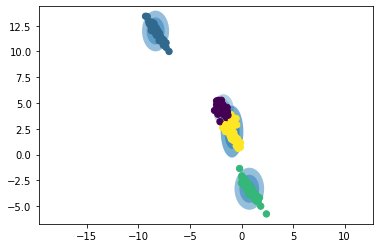

In [88]:
gmm = GaussianMixture(n_components=4, covariance_type='diag')
plot_gmm(gmm, X_stretched)

Diagonal 공분산 행렬을 사용하면 full 공분산 행렬보다 계산 복잡도가 낮지만, 이에 반해 fitting 되는 가우시안은 덜 정교하다는 것을 볼 수 있다.

Spherical:

$$
\Sigma=\sigma^2\left[\begin{array}{ccc}
1 & \cdots & 0 \\
\vdots & \ddots & \vdots \\
0 & \cdots & 1
\end{array}\right]
$$


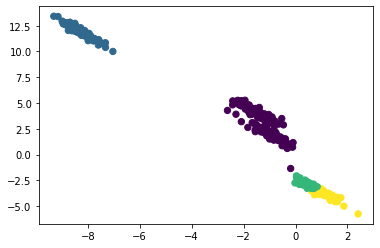

In [91]:
gmm = GaussianMixture(n_components=4, covariance_type='spherical').fit(X_stretched)
labels = gmm.predict(X_stretched)
plt.scatter(X_stretched[:, 0], X_stretched[:, 1], c=labels, s=40, cmap='viridis');

마지막으로 Spherical 공분산 행렬을 사용해 가우시안을 fitting 한 모형이다. 앞선 두 공분산 행렬에서 두개로 분류된 cluster 를 하나의 가우시안으로 분류 하였고, 반면 하나로 분류한 cluster 을 두개의 가우시안으로 분류한 모습이다. 계산 복잡도가 아주 낮다는 장점이 있지만, diagonal 과 full 공분산 행렬을 사용했을 때 보다 성능이 좋지 않다는 것을 알 수 있다.

------------

### Kernel Density Estimation

이전에 살펴보았던 밀도기반 이상치 탐지 방법론들은 데이터가 가우시안을 따른다는 가정을 통해 분포를 fitting 하였다. 하지만 Kernel Density Estimation 은 사전적으로 데이터 분포에 대한 가정 **없이** 밀도를 추정해 나가는 비모수 밀도추정 방법론이다.

Unknow distribution 에서부터 i.i.d 로 관측된 $n$ 개의 샘플이 존재한다면, Kernel density 는 다음과 같이 추정 할 수 있다.

$$
p(x)=\frac{1}{n h} \Sigma_{j=1}^n K\left(\frac{x-x_j}{h}\right)
$$

이때 $K$ 는 커널함수이며, $h$ 는 hyperparameter 로 smoothing parameter, 혹은 bandwith 라고도 불린다.

가장 기본적인 커널함수 $K$ 는 다음과 같다.

$$
K(u)=\left\{\begin{array}{ll}
1 & \left|u_j\right|<\frac{1}{2} \forall j=1, \ldots d \\
0 & \text { otherwise }
\end{array}\right\}
$$

즉, bandwidth $h$ 를 고정시킨 뒤 각 면의 길이가 $h$ 인 hypercube 가 데이터 공간을 sliding 하며, 커널 함수를 통해 hypercube 내부에 몇개의 객체 $k$ 가 위치하는지 찾는 것이 커널 밀도 추정의 목적이다.

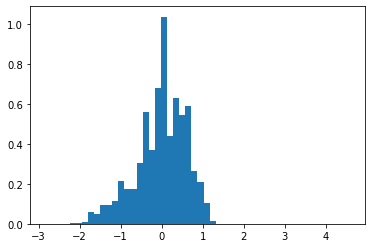

In [2]:
x = np.array(df['V24'])
x.shape
hist = plt.hist(x, bins=50, density = True)

데이터 시각화를 위해 자주 사용되는 `matplotlib.pyplot.hist` 함수에 `density=True` 인자를 주면 쉽게 커널밀도추정을 구현 할 수 있다.

하지만 커널밀도추정에서 사용되는 커널함수 $K$ 의 단점 또한 이 histogram 에서 찾을 수 있다. 커널밀도추정은 커널함수를 통해 각 면의 길이가 $h$ 인 hypercube 를 sliding 하며 $p(x)$ 를 계산하는데, 이 hypercube 의 border 에 애매하게 위치한 객체들에게도 **동등한 가중치**를 부여한다. 그렇기 때문에 불연속적인 추정을 할 수 밖에 없으며, 위의 histogram 또한 불연속적인 값으로 나타나는 것이다.

#### Different Kernel Functions

연속적인 추정을 위해서 커널 함수를 다르게 설정 할 수 있다. 대표적인 예시로는 가우시안 커널이 있는데, 기존 커널함수와는 달리 window 내부에 객체가 위치해 있을 확률에 따라 기여도를 부여함으로써 연속적인 추정을 가능캐 한다. 가우시안 커널 이외에도 Kernel based learning 에서 사용 한 것 처럼 사용자가 정의한 커널 함수를 사용 할 수도 있다.

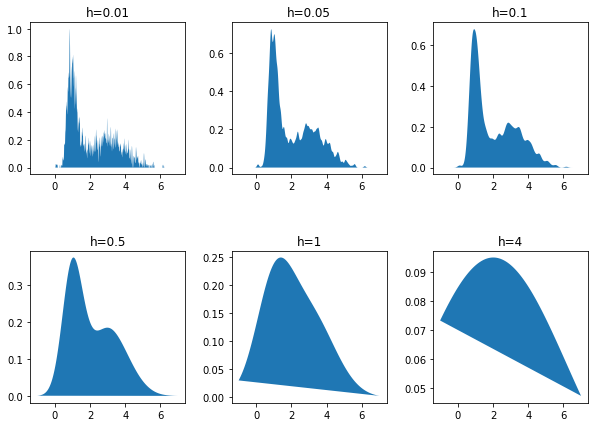

In [58]:
def generate_data(seed=42):
    rand = np.random.RandomState(seed)
    x = []
    dat = rand.lognormal(0, 0.3, 1000)
    x = np.concatenate((x, dat))
    dat = rand.normal(3, 1, 1000)
    x = np.concatenate((x, dat))
    return x

x_train = generate_data()[:, np.newaxis]
x_test = np.linspace(-1, 7, 2000)[:, np.newaxis]

bandwidths = [0.01, 0.05, 0.1, 0.5, 1, 4]
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 7))
plt_ind = np.arange(6) + 231

for b, ind in zip(bandwidths, plt_ind):
    kde_model = KernelDensity(kernel='gaussian', bandwidth=b)
    kde_model.fit(x_train)
    score = kde_model.score_samples(x_test)
    plt.subplot(ind)
    plt.fill(x_test, np.exp(score))
    plt.title(f'h={b}')

fig.subplots_adjust(hspace=0.5, wspace=.3);


위 예시는 불연속적인 커널 함수 대신 가우시안 커널을 사용하여 추정을 한 결과이다. 가우시안 커널을 통한 밀도추정은 다음과 같이 나타낼 수 있다.
$$
p(x)=\frac{1}{N} \Sigma_{j=1}^n K\left(\frac{x-x_j}{h}\right)
$$

이때 smoothing parameter, 혹은 bandwidth $h$ 의 변화에 따른 결과를 볼 수 있다. Bandwidth 는 가우시안 커널 자체의 크기를 조절하는 파라미터로, 작을수록 각 객체가 특정 window 내에 위치할 확률을 계산할 때 주변 객체의 수가 줄어든다.

---------------

## Model Based Anomaly Detection

밀도 기반 이상치 탐지와는 달리, 모델 기반 이상치 탐지는 주어진 데이터를 통해 특정 모델을 학습시킨 뒤, 이상치를 추정하는 방법론들이다.

### Isolation Forest

Isolation Forest (이하 IF) 는 이름에서 알 수 있듯이 출처는 의사결정나무이다. IF 의 핵심 아이디어는 데이터 속 이상치는 개체 수가 적고, 정상 범주 데이터와는 특정 속성 값이 다를 가능성이 높다는 것에 기반한다.

그렇기에 IF 는 데이터 속 각 객체를 의사결정나무의 분기로 고립시키는데, 각 객체를 고립시키는데 있어서 **많은 분기가 필요하다면 정상 객체로 판단**하며, 상대적으로 **적은 분기가 필요하다면 해당 객체를 이상치로 판단**한다.

IF 의 가장 큰 장점 중 하나는 바로 객체를 고립시키는데 있어서 필요한 분기로 이상치 점수를 부여 할 수 있다는 점이다. 그렇기에 사용자에게도 정량적인 평가척도를 제시하며, 결과를 공유하는데 있어서 설명이 명확해진다.

V12 V4


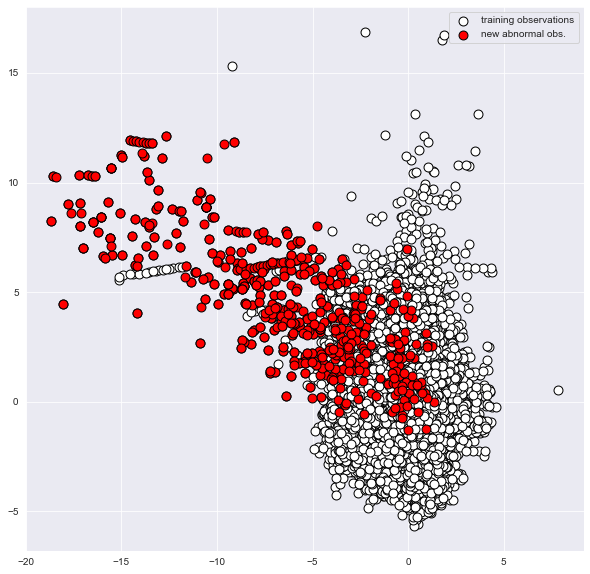

In [128]:
varlist = df.columns.to_list()
rm = ['Time', 'Amount', 'Class']
for i in rm:
    varlist.remove(i)
rand_1 = random.choice(varlist)
rand_2 = random.choice(varlist)
print(rand_1, rand_2)

X_train, X_test = train_test_split(df[[rand_1, rand_2]], test_size=0.2, random_state=42)
X_outliers = df.loc[df['Class']==1][[rand_1, rand_2]]

plt.rcParams['figure.figsize'] = [10, 10]
p1 = plt.scatter(X_train[rand_1], X_train[rand_2], c='white', s=20*4, edgecolor='k', label='training observations')
p3 = plt.scatter(X_outliers[rand_1], X_outliers[rand_2], c='red', s=20*4, edgecolor='k', label='new abnormal obs.')

plt.legend();

#### Training and Inference

이전 예시들과 동일하게 데이터셋의 2개의 변수를 랜덤하게 추출 후, IF 모델의 학습을 위해 학습용 데이터와 검증용 데이터로 나누었다.

Test Data Accuracy: 0.8063270250342334
Outlier Data Accuracy: 0.9105691056910569


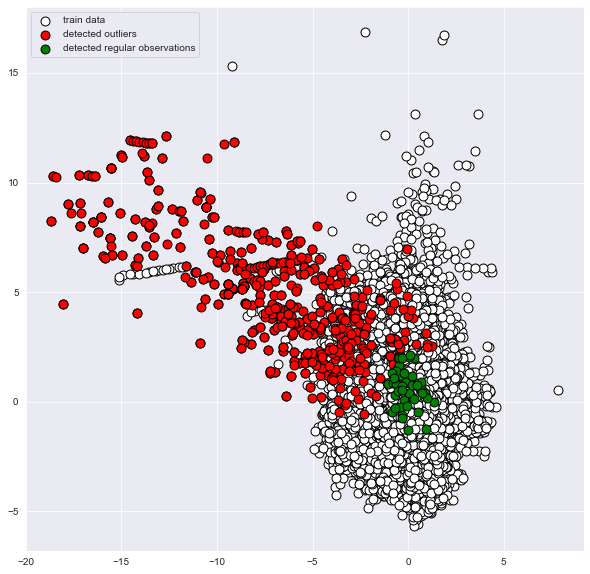

In [129]:
clf = IsolationForest()
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
X_outliers_plot = X_outliers.assign(y = y_pred_outliers)

p1 = plt.scatter(X_train[rand_1], X_train[rand_2], c='white',
                 s=20*4, edgecolor='k', label="train data")
p2 = plt.scatter(X_outliers_plot.loc[X_outliers_plot.y == -1, [rand_1]], 
                 X_outliers_plot.loc[X_outliers_plot.y == -1, [rand_2]], 
                 c='red', s=20*4, edgecolor='k', label="detected outliers")
p3 = plt.scatter(X_outliers_plot.loc[X_outliers_plot.y == 1, [rand_1]], 
                 X_outliers_plot.loc[X_outliers_plot.y == 1, [rand_2]], 
                 c='green', s=20*4, edgecolor='k', label="detected regular observations")
plt.legend();

print("Test Data Accuracy:", list(y_pred_test).count(1)/y_pred_test.shape[0])
print("Outlier Data Accuracy:", list(y_pred_outliers).count(-1)/y_pred_outliers.shape[0])

In [130]:
anomaly_sample = df.loc[df.Class==1].iloc[0]
regular_sample = df.loc[df.Class==0].iloc[0]
anomaly_sample = np.array(anomaly_sample[[rand_1, rand_2]]).reshape(1,-1)
regular_sample = np.array(regular_sample[[rand_1, rand_2]]).reshape(1,-1)

print(f'Predicted class of the anomaly sample: {clf.predict(anomaly_sample).item()}')
print(f'Predicted IF Score of the anomaly sample: {-clf.score_samples(anomaly_sample).item()}')
print(f'Predicted class of the regular sample: {clf.predict(regular_sample).item()}')
print(f'Predicted If Score of the regular sample: {-clf.score_samples(regular_sample).item()}')


Predicted class of the anomaly sample: -1
Predicted IF Score of the anomaly sample: 0.7141914915024071
Predicted class of the regular sample: 1
Predicted If Score of the regular sample: 0.46249944548984184


학습이 완료 된 후, 모델에 각각 이상치 데이터와 일반 데이터에 대한 inference 진행 시, 각 class 가 잘 예측 되는 것을 볼 수 있다. 이때 IF Score 은 0과 1 사이로 계산되며, 1에 가까울 수록 모델이 해당 객체를 이상치라고 판단한다.